In [22]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

In [23]:
df = r"VU_DM_Data/submission_sample.csv"
df = pd.read_csv(df)
df.head()

,srch_id,prop_id
0,1,3180
1,1,5543
2,1,14142
3,1,22393
4,1,24194


In [24]:
train = r"VU_DM_data/Train_final.csv"
df_train = pd.read_csv(train)
df_train.head()

,srch_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,...,orig_destination_distance,random_bool,click_bool,booking_bool,price_usd_norm_by_srch_id,price_usd_norm_by_prop_id,prop_starrating_norm_by_srch_id,prop_location_score1_norm_by_srch_id,prop_review_score_norm_by_srch_id,estimated_position
0,1,7.26543,14.924114,893,3,3.5,1,2.83,0.0182,4.95,...,386.6,1,0,0,-0.906230,-0.762514,-0.093205,1.022407,0.016094,0.037809
1,1,7.26543,14.924114,10404,4,4.0,1,2.20,0.0182,5.03,...,386.6,1,0,0,0.345195,0.836064,1.211671,-0.192089,0.466718,0.042151
2,1,7.26543,14.924114,21315,3,4.5,1,2.20,0.0182,4.92,...,386.6,1,0,0,0.477681,0.565701,-0.093205,-0.192089,0.917342,0.044553
3,1,7.26543,14.924114,27348,2,4.0,1,2.83,0.0182,4.39,...,386.6,1,0,0,3.577428,7.967538,-1.398082,1.022407,0.466718,0.033579
4,1,7.26543,14.924114,29604,4,3.5,1,2.64,0.0182,4.93,...,386.6,1,0,0,-0.098745,0.714899,1.211671,0.656130,0.016094,0.132398


In [25]:
df_train[df_train['price_usd']>5000].count()

srch_id                                 0
visitor_location_country_id             0
prop_country_id                         0
prop_id                                 0
prop_starrating                         0
prop_review_score                       0
prop_brand_bool                         0
prop_location_score1                    0
prop_location_score2                    0
prop_log_historical_price               0
price_usd                               0
promotion_flag                          0
srch_destination_id                     0
srch_length_of_stay                     0
srch_booking_window                     0
srch_adults_count                       0
srch_children_count                     0
srch_room_count                         0
srch_saturday_night_bool                0
orig_destination_distance               0
random_bool                             0
click_bool                              0
booking_bool                            0
price_usd_norm_by_srch_id         

In [26]:
test = r"VU_DM_data/Test_final.csv"
df_test = pd.read_csv(test)
df_test.head()

,srch_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,...,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,price_usd_norm_by_srch_id,price_usd_norm_by_prop_id,prop_starrating_norm_by_srch_id,prop_location_score1_norm_by_srch_id,prop_review_score_norm_by_srch_id,estimated_position
0,1,12.288496,14.921711,3180,3,4.5,1,2.94,0.0182,5.03,...,1,0,387.85,0,0.783348,-0.527931,0.435686,0.928059,0.513567,0.066815
1,1,12.288496,14.921711,5543,3,4.5,1,2.64,0.0182,4.93,...,1,0,387.85,0,0.762316,0.109328,0.435686,-0.068745,0.513567,0.148936
2,1,12.288496,14.921711,14142,2,3.5,1,2.71,0.0182,4.16,...,1,0,387.85,0,-1.428079,-0.660022,-0.968192,0.163842,-0.550250,0.059514
3,1,12.288496,14.921711,22393,3,4.5,1,2.40,0.0182,5.03,...,1,0,387.85,0,1.241237,0.406295,0.435686,-0.866188,0.513567,0.051178
4,1,12.288496,14.921711,24194,3,4.5,1,2.94,0.0182,4.72,...,1,0,387.85,0,-0.237687,-0.454957,0.435686,0.928059,0.513567,0.069329


In [27]:
# Takes about 20 mins 0n 4.9 mil instances
def create_submission(model1, model2, Test_data, proba = False):
    import time
    start = time.time()
    
    Test = Test_data
    #predictions
    print("~ Making predictions")
    if proba == True:
        clickpreds = model1.predict_proba(Test.drop(['srch_id','prop_id'], axis = 1))
        bookpreds = model2.predict_proba(Test.drop(['srch_id','prop_id'], axis = 1))
        
        Test['click_preds'] = pd.DataFrame(clickpreds)[1].values
        Test['booking_preds'] = pd.DataFrame(bookpreds)[1].values
    else:
        clickpreds = model1.predict(Test.drop(['srch_id','prop_id'], axis = 1))
        bookpreds = model2.predict(Test.drop(['srch_id','prop_id'], axis = 1))
    
        Test['click_preds'] = clickpreds
        Test['booking_preds'] = bookpreds
    
    #Grab 4 columns from Test
    sub = Test[['srch_id','prop_id','click_preds','booking_preds']]
    #Weight booking column values
    
    if proba == True:
        sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x*2 if x > 0 else x)
    else:
        sub['booking_preds'] = sub['booking_preds'].apply(lambda x: x+1 if x > 0 else x)
    #Total click & booking values, remove columns
    sub['total'] = sub['click_preds']+sub['booking_preds']
    sub.drop(['click_preds', 'booking_preds'], axis = 1, inplace = True)
    
    #Sort chunks of srch ids by 'total' value
    print(f"~ Sorting chunks of srch_ids: {(time.time()-start):.2f}s have passed")
    ids = sub['srch_id'].unique()
    sub1 = pd.DataFrame()
    k=0
    
    srch_id = []
    prop_id = []
    total = []
    for item in ids:
       
        df = sub[sub['srch_id'] == item].sort_values('total', ascending = False)
        srch_id.append(df['srch_id'].values)
        prop_id.append(df['prop_id'].values)
        total.append(df['total'].values)
    
        k+=1
        if not k%10000:
            print(f"{k}/{len(ids)} srch_ids, time elapsed: {(time.time() - start):.2f}s")

    #Unpack list of arrays
    print(f"~ Unpacking lists: {(time.time() - start):.2f}s elapsed")
    _srch_id = []
    for i in range(0,len(srch_id)):
        for k in range(0,len(srch_id[i])):
            _srch_id.append(srch_id[i][k])
    _prop_id = []
    for i in range(0,len(prop_id)):
        for k in range(0,len(prop_id[i])):
            _prop_id.append(prop_id[i][k])
    _total = []
    for i in range(0,len(total)):
        for k in range(0,len(total[i])):
            _total.append(total[i][k])
    
    #Create Dataframe from unpacked lists
    print(f"~ Creating Dataframe: {(time.time() - start):.2f}s elapsed")
    sub2 = pd.DataFrame(zip(_srch_id, _prop_id, _total),
               columns =['srch_id', 'prop_id','total'])
    
    sub1 = sub2[['srch_id','prop_id']]
    
    print(f"~ Finished. Total time: {(time.time() - start):.2f}")
    return(sub1, sub2)
    
    
    

In [28]:
X_train = df_train.drop(['srch_id', 'prop_id','click_bool', 'booking_bool'], axis = 1)
Y1_train = df_train['click_bool']
Y2_train = df_train['booking_bool']

In [29]:
LGBMclick = lgb.LGBMClassifier(scale_pos_weight = 12, n_estimators = 76)
LGBMbook = lgb.LGBMClassifier(scale_pos_weight = 12, n_estimators = 78)

In [30]:
LGBMclick.fit(X_train, Y1_train)
LGBMbook.fit(X_train, Y2_train)

LGBMClassifier(n_estimators=78, scale_pos_weight=12)

Text(0.5, 1.0, 'LightGBM Click Model: Features by Importance')

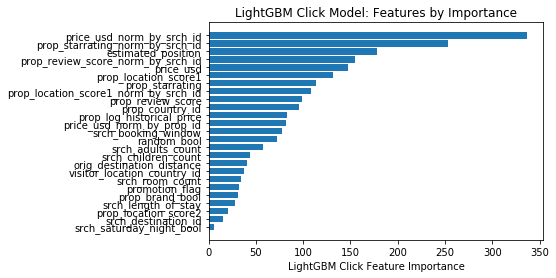

In [31]:
sorted_idx = LGBMclick.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], LGBMclick.feature_importances_[sorted_idx])
plt.xlabel("LightGBM Click Feature Importance")
plt.title("LightGBM Click Model: Features by Importance")

Text(0.5, 1.0, 'LightGBM Booking Model: Features by Importance')

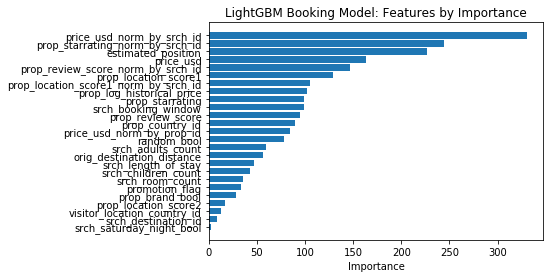

In [32]:
sorted_idx = LGBMbook.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], LGBMbook.feature_importances_[sorted_idx])
plt.xlabel("Importance")
plt.title("LightGBM Booking Model: Features by Importance")

In [33]:
results = create_submission(LGBMclick,LGBMbook,df_test, proba = True)

~ Making predictions


/Users/jerenolsen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jerenolsen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jerenolsen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

~ Sorting chunks of srch_ids: 46.98s have passed
10000/199549 srch_ids, time elapsed: 105.64s
20000/199549 srch_ids, time elapsed: 162.55s
30000/199549 srch_ids, time elapsed: 224.92s
40000/199549 srch_ids, time elapsed: 291.97s
50000/199549 srch_ids, time elapsed: 357.94s
60000/199549 srch_ids, time elapsed: 421.69s
70000/199549 srch_ids, time elapsed: 486.06s
80000/199549 srch_ids, time elapsed: 553.93s
90000/199549 srch_ids, time elapsed: 626.92s
100000/199549 srch_ids, time elapsed: 691.84s
110000/199549 srch_ids, time elapsed: 759.40s
120000/199549 srch_ids, time elapsed: 823.40s
130000/199549 srch_ids, time elapsed: 889.32s
140000/199549 srch_ids, time elapsed: 954.11s
150000/199549 srch_ids, time elapsed: 1019.23s
160000/199549 srch_ids, time elapsed: 1089.45s
170000/199549 srch_ids, time elapsed: 1158.14s
180000/199549 srch_ids, time elapsed: 1224.41s
190000/199549 srch_ids, time elapsed: 1288.50s
~ Unpacking lists: 1349.88s elapsed
~ Creating Dataframe: 1354.31s elapsed
~ Fini

In [34]:
results[1]

,srch_id,prop_id,total
0,1,99484,1.982659
1,1,61934,1.945618
2,1,54937,1.539606
3,1,28181,1.508317
4,1,50162,1.473165
...,...,...,...
4959178,329066,115193,0.384913
4959179,329066,5650,0.383222
4959180,329066,103818,0.327404
4959181,329066,44241,0.274319


In [35]:
results[0]

,srch_id,prop_id
0,1,99484
1,1,61934
2,1,54937
3,1,28181
4,1,50162
...,...,...
4959178,329066,115193
4959179,329066,5650
4959180,329066,103818
4959181,329066,44241


In [40]:
results[0].to_csv('/Users/jerenolsen/desktop/kaggle_preds_submission.csv',index=False)

In [37]:
df_train['estimated_position'].median()

0.05725190839694658

In [38]:
import seaborn as sns

In [41]:
print(len(results[0]))

4959183
